In [2]:
import numpy as np
import scipy.misc
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import scipy.misc
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def n_bib(balls,bins):
    return scipy.misc.comb(balls+bins-1,balls)

In [5]:
def n_st(n_balls,n_arms): #excluding terminal state
    return int(np.sum([n_bib(i,n_arms*2) for i in range(n_balls+1)]))

In [6]:
def check(T,b):
    a = np.where(np.all(T==b,axis=1))
    if len(a[0]) > 0:
        return a[0][0]
    else:
        return -1

In [7]:
n_arms = 2
n_balls = 2
S = np.ones((1,n_arms*2)) # All possible states
balls = 0
ipb = 0 # index of previous basis
count_added = 0 # number of states added with the current number of balls
while balls < n_balls:
    for j in range(count_added+1): # use each of the states added with balls-1 as bases
        for i in range(n_arms*2): # Distribute the ball to each bin
            new = S[ipb].copy()
            new[i] += 1 
            S = np.vstack((S,new))
            count_added += 1
        count_added -= 1
        ipb += 1
    balls += 1

In [8]:
S

array([[ 1.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.],
       [ 1.,  2.,  1.,  1.],
       [ 1.,  1.,  2.,  1.],
       [ 1.,  1.,  1.,  2.],
       [ 3.,  1.,  1.,  1.],
       [ 2.,  2.,  1.,  1.],
       [ 2.,  1.,  2.,  1.],
       [ 2.,  1.,  1.,  2.],
       [ 2.,  2.,  1.,  1.],
       [ 1.,  3.,  1.,  1.],
       [ 1.,  2.,  2.,  1.],
       [ 1.,  2.,  1.,  2.],
       [ 2.,  1.,  2.,  1.],
       [ 1.,  2.,  2.,  1.],
       [ 1.,  1.,  3.,  1.],
       [ 1.,  1.,  2.,  2.],
       [ 2.,  1.,  1.,  2.],
       [ 1.,  2.,  1.,  2.],
       [ 1.,  1.,  2.,  2.],
       [ 1.,  1.,  1.,  3.]])

In [9]:
def states(n_balls,n_arms,rewardCorrect=1.0,cost=-1):
    
    if cost == -1: # Set cost to horizon-bounding value by default
        cost = rewardCorrect/n_balls
        
    S = np.ones((1,n_arms*2)) # Matrix of all possible states

    n_states = n_st(n_balls,n_arms) # Number of all possible states
    T1 = np.zeros((n_states+1,n_states+1,n_arms)) # Transition tensor

    balls = 0 # Counter for which observation is happening
    ipb = 0 # Index of previous basis
    count_added = 0 # Number of states added with the current number of balls
    state_count = 0

    while balls < n_balls:
        for j in range(count_added+1): # Use each of the states added with balls-1 observations as bases
            for i in range(n_arms*2): # Distribute the ball to each bin
                new = S[ipb].copy() # Copy the previous basis

                # Get the probability of making this observation
                if i%2 == 0: #ON or OFF observation
                    p = new[i]/(new[i] + new[i+1])
                else:
                    p = new[i]/(new[i] + new[i-1])

                # Prepare and add the new state generated by the observation
                new[i] += 1 
                k = check(S,new)

                if k == -1: #If it isn't already added
                    S = np.vstack((S,new))
                    count_added += 1
                    state_count += 1
                    T1[ipb,state_count,i//2] = p 
                else:
                    T1[ipb,k,i//2] = p
            count_added -= 1 # Remove the added one to balance after the initial case
            ipb += 1 # Move down the previously added states at observation balls-1
        balls += 1   

    S = np.vstack((S,-np.ones((1,n_arms*2)))) #Add the terminal state

    for i in range(n_states):
        if np.sum(S[i]) >= 2*n_arms+n_balls:
            T1[i,-1] = np.ones(n_arms)

    # The terminal state always goes back to itself
    t = np.zeros((n_states+1,n_arms))
    t[-1,:] = 1
    T1[-1] = t

    T2 = np.zeros((n_states+1,n_states+1,1))
    T2[:,-1] = 1

    T = np.concatenate((T1,T2),axis=2)

    R = -cost*np.ones((n_states+1,n_arms+1))
    p = np.max([[s[2*j]/(s[2*j+1]+s[2*j]) for j in range(n_arms)] for s in S],1)
    R[:,-1] = rewardCorrect*p
    R[-1,:] = 0
    
    
    return S,T,R

In [10]:
S = states(3,2)[0]
print(S)

[[ 1.  1.  1.  1.]
 [ 2.  1.  1.  1.]
 [ 1.  2.  1.  1.]
 [ 1.  1.  2.  1.]
 [ 1.  1.  1.  2.]
 [ 3.  1.  1.  1.]
 [ 2.  2.  1.  1.]
 [ 2.  1.  2.  1.]
 [ 2.  1.  1.  2.]
 [ 1.  3.  1.  1.]
 [ 1.  2.  2.  1.]
 [ 1.  2.  1.  2.]
 [ 1.  1.  3.  1.]
 [ 1.  1.  2.  2.]
 [ 1.  1.  1.  3.]
 [ 4.  1.  1.  1.]
 [ 3.  2.  1.  1.]
 [ 3.  1.  2.  1.]
 [ 3.  1.  1.  2.]
 [ 2.  3.  1.  1.]
 [ 2.  2.  2.  1.]
 [ 2.  2.  1.  2.]
 [ 2.  1.  3.  1.]
 [ 2.  1.  2.  2.]
 [ 2.  1.  1.  3.]
 [ 1.  4.  1.  1.]
 [ 1.  3.  2.  1.]
 [ 1.  3.  1.  2.]
 [ 1.  2.  3.  1.]
 [ 1.  2.  2.  2.]
 [ 1.  2.  1.  3.]
 [ 1.  1.  4.  1.]
 [ 1.  1.  3.  2.]
 [ 1.  1.  2.  3.]
 [ 1.  1.  1.  4.]
 [-1. -1. -1. -1.]]


In [11]:
T = states(3,2)[1]
print(T[-2,:,0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [12]:
T = states(3,2)[1]
print(T[:,:,-1])

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [23]:
R = states(3,3)[2]
print(R)

[[-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.75      ]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.66666667]
 [-0.33333333 -0.33333333 -0.33333333  0.5       ]
 [-0.33333333 -0.33333333 -0.33333333  0.75      ]
 [-0.33333333 -0.33333333 -0.33

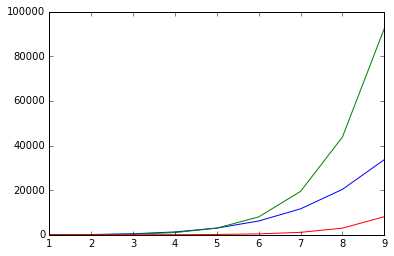

In [14]:
nums=np.arange(1,10)
ns_arm= [n_st(5,a) for a in nums] # Observations is constant, lightbulbs are incresing
ns_ball= [n_st(a,5) for a in nums] # Lighbulbs are constant, observations are increasing
plt.plot(nums,ns_arm)
plt.plot(nums,ns_ball)
plt.plot(nums,np.exp(nums))

In [47]:
n_balls=5
n_arms=5
print(n_st(n_balls,n_arms))

3003


In [32]:
s = states(n_balls,n_arms,cost=0.01)
a = {'states':s[0],'transition':s[1],'rewards':s[2]}
scipy.io.savemat('./file',a)

In [33]:
len(s[0])

85

In [34]:
steps = np.sum(s[0][-2,:])
steps

9.0

In [35]:
np.sum(s[1][-2,:,2])

1.0

In [36]:
s[0][-2]

array([ 1.,  1.,  1.,  1.,  1.,  4.])

In [37]:
c = 0.0
T = s[1]
n_states = n_st(n_balls,n_arms)
for i in range(n_states):
    for j in range(n_arms+1):
        if np.sum(T[i,:,j])!=1:
            c+=1 
print(c)
print(c/(n_states*(n_arms+1)))

0.0
0.0
